In [1]:
from matplotlib import pyplot as plt
import common as co
import os
import sacc
import numpy as np
from cl import Cl, Cl_fid, Field
from cov import Cov
from scipy.interpolate import interp1d
from scipy import stats

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Null test gc-sh

In [52]:
# These are the ell_cuts in the MCMC's:
# https://github.com/carlosggarcia/montepython_public/blob/emilio/cl_cross_corr_params_v2/cl_cross_corr_v2_gcgc_gcwl_wlwl.yml
ell_cuts = {'DESgc0': 145,
            'DESgc1': 225,
            'DESgc2': 298,
            'DESgc3': 371,
            'DESgc4': 435}

def get_chi2(sCgng):
    cl = sCgng.mean
    dof = cl.size
    cov = sCgng.covariance.covmat
    chi2 = cl.dot(np.linalg.inv(cov)).dot(cl)
    pte = 100 * (1 - stats.chi2.cdf(chi2, dof))
    print(f'chi2 = {chi2:.1f}', f'dof = {dof}', f'PTE(%) ={pte:.1f}')

In [53]:
# sCgng = sacc.Sacc.load_fits('/mnt/extraspace/gravityls_3/S8z/Cls_2/4096_asDavid_recompute_newfid/cls_covG_covNG_DESgc_DESwl.fits')

# # Remove all dtypes except for gc-sh (B-modes)
# ell, _ = sCgng.get_ell_cl('cl_00', tracer1='DESgc0', tracer2='DESgc0')
# tracers = sCgng.get_tracer_combinations(data_type='cl_0b')

# for dtype in sCgng.get_data_types():
#     if dtype != 'cl_0b':    
#         sCgng.remove_selection(data_type=dtype)
    
# assert sCgng.mean.size, ell.size * len(tracers)
# assert sCgng.get_tracer_combinations() == tracers

# # Only scales in the MCMC
# sCgng_cuts = sCgng.copy()
# for tr1, tr2 in tracers:
#     ell_cut = ell_cuts[tr1]
#     sCgng_cuts.remove_selection(data_type='cl_0b', tracers=(tr1, tr2), ell__gt=ell_cut)
    
print('Full')
get_chi2(sCgng)
print('Cut ')
get_chi2(sCgng_cuts)

Full
chi2 = 722.7 dof = 780 PTE(%) =92.9
Cut 
chi2 = 176.4 dof = 188 PTE(%) =71.8


# Noise marginalization

In [2]:
sCgng = sacc.Sacc.load_fits('/mnt/extraspace/gravityls_3/S8z/Cls_2/4096_asDavid_recompute_newfid/cls_covG_covNG_DESgc_DESwl.fits')
sCng = sacc.Sacc.load_fits('/mnt/extraspace/gravityls_3/S8z/Cls_2/4096_asDavid_recompute_newfid/nls_covNG.fits')

In [3]:
sCgng_marg = sCgng.copy()

In [15]:
ix = sCgng_marg.indices(data_type='cl_00', tracers=('DESgc0', 'DESgc0'))
print(ix)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


In [12]:
i = 0
trs = (f'DESgc{i}', f'DESgc{i}')
ell, nl = sCng.get_ell_cl(data_type='cl_00', tracer1=trs[0], tracer2=trs[1])
print(nl.shape)
print(np.all(nl[:, None] * nl[None, :] == nl[None, :] * nl[:, None]))
ell, cl, cov = sCgng_marg.get_ell_cl(data_type='cl_00', tracer1=trs[0], tracer2=trs[1], return_cov=True)
print(np.all(sCgng_marg.covariance.covmat[np.ix_(ix, ix)] == sCgng_marg.covariance.covmat[ix, :][:, ix]))
print(np.all(sCgng_marg.covariance.covmat[np.ix_(ix, ix)] == cov))

(39,)
True


In [27]:
# Uncomment to produce GNG + marginalized

# sigma = 0.1
# for i in range(5):
#     trs = (f'DESgc{i}', f'DESgc{i}')
#     ix = sCgng_marg.indices(data_type='cl_00', tracers=trs)
#     _, _, cov = sCgng.get_ell_cl(data_type='cl_00', tracer1=trs[0], tracer2=trs[1], return_cov=True)
#     ell, nl = sCng.get_ell_cl(data_type='cl_00', tracer1=trs[0], tracer2=trs[1])
#     cov_marg = sigma**2 * nl[:, None] * nl[None, :]
#     sCgng_marg.covariance.covmat[np.ix_(ix, ix)] += cov_marg
    
#     _, _, cov2 = sCgng_marg.get_ell_cl(data_type='cl_00', tracer1=trs[0], tracer2=trs[1], return_cov=True)
#     assert np.all(cov2 == cov_marg + cov)
# sCgng_marg.save_fits('/mnt/extraspace/gravityls_3/S8z/Cls_2/4096_asDavid_recompute_newfid/cls_covG_covNG_DESgc_DESwl_SNMarginalized.fits')

In [29]:
sCgng_marg = sacc.Sacc.load_fits('/mnt/extraspace/gravityls_3/S8z/Cls_2/4096_asDavid_recompute_newfid/cls_covG_covNG_DESgc_DESwl_SNMarginalized.fits')
for i in range(5):
    trs = (f'DESgc{i}', f'DESgc{i}')
    ix = sCgng_marg.indices(data_type='cl_00', tracers=trs)
    _, _, cov = sCgng.get_ell_cl(data_type='cl_00', tracer1=trs[0], tracer2=trs[1], return_cov=True)
    ell, nl = sCng.get_ell_cl(data_type='cl_00', tracer1=trs[0], tracer2=trs[1])
    cov_marg = sigma**2 * nl[:, None] * nl[None, :]
    
    _, _, cov2 = sCgng_marg.get_ell_cl(data_type='cl_00', tracer1=trs[0], tracer2=trs[1], return_cov=True)
    assert np.all(cov2 == cov_marg + cov)

# Fake data with h=0.8

In [19]:
sCgng_marg = sacc.Sacc.load_fits('/mnt/extraspace/gravityls_3/S8z/Cls_2/4096_asDavid_recompute_newfid/cls_covG_covNG_DESgc_DESwl_SNMarginalized.fits')
sFid = sacc.Sacc.load_fits('/mnt/extraspace/gravityls_3/S8z/Cls_2/4096_asDavid_recompute_newfid_H080/clsFid_covG_DESonly.fits')
sFidOld = sacc.Sacc.load_fits('/mnt/extraspace/gravityls_3/S8z/Cls_2/4096_asDavid/clfid_covG.fits')

In [5]:
sCgng_marg.get_tracer_combinations() == sFid.get_tracer_combinations()

True

In [13]:
mean = sFid.mean
cov = sCgng_marg.covariance.covmat
# noisy_mean = stats.multivariate_normal(mean, cov, allow_singular=True).rvs()
noisy_mean = np.random.multivariate_normal(mean, cov)

In [14]:
sFakeData = sFid.copy()
sFakeData.mean = noisy_mean
sFakeData.covariance.covmat = cov
sFakeData.save_fits('/mnt/extraspace/gravityls_3/S8z/Cls_2/4096_asDavid_recompute_newfid_H080/clsFakeData_covG_covNG_DESonly_SNMarginalized.fits')

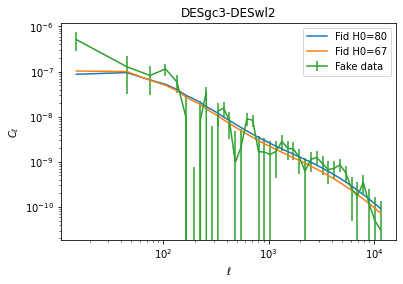

In [25]:
tr1 = 'DESgc3'
tr2 = 'DESwl2'
dtype = 'cl_0e'
#
ell, cl = sFid.get_ell_cl(dtype, tr1, tr2)
plt.loglog(ell, cl, label='Fid H0=80')
#
ell, cl = sFidOld.get_ell_cl(dtype, tr1, tr2)
plt.loglog(ell, cl, label='Fid H0=67')
#
ell, cl, cov = sFakeData.get_ell_cl(dtype, tr1, tr2, return_cov=True)
err = np.sqrt(np.diag(cov))
plt.errorbar(ell, cl, yerr=err, label='Fake data')
#
plt.legend(loc=0)
plt.title(tr1 + '-' + tr2)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.show()
plt.close()